## **MLP Sentiment Analysis IMDB**

In [ ]:
!pip -q install nltk textblob

In [59]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/IMDB_Project"
os.makedirs(project_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the necessary libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Load the IMDB Dataset

In [3]:
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [4]:
df = pd.read_csv(path+"/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Text Preprocessing

In [5]:
def clean_text(text):
    text = text.lower() #Lowercase
    text = re.sub(r'<.*?>', '', text) #Removing HTML Tags
    text = " ".join(text.split()) #Removing extra spaces
    return text
df["review_clean"] = df["review"].astype(str).apply(clean_text)

df.head()

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


Feature Engineering

In [6]:
analyzer = SentimentIntensityAnalyzer()

df["vader_pos"] = df["review_clean"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
df["vader_neu"] = df["review_clean"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
df["vader_neg"] = df["review_clean"].apply(lambda x: analyzer.polarity_scores(x)["neg"])
df["vader_compound"] = df["review_clean"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

df["textblob_polarity"] = df["review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["textblob_subjectivity"] = df["review_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Label Encoding

In [7]:
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

Features Scaling

In [8]:
X = df[
    [
        "vader_pos",
        "vader_neu",
        "vader_neg",
        "vader_compound",
        "textblob_polarity",
        "textblob_subjectivity"
    ]
]

y = df["label"]

Train / Validation / Test Split

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

**Build and Train MLP Model**

Initialize Parameters

In [126]:
np.random.seed(42)

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
b2 = np.zeros((1, output_size))

learning_rate = 0.05

Activation Functions

In [118]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

Logistic Regressison

In [131]:
epochs = 1000
train_losses = []
val_losses = []

# Convert to numpy (if they are pandas series) and reshape to (m, 1)
if hasattr(y_train, 'values'):
    y_train = y_train.values
if hasattr(y_val, 'values'):
    y_val = y_val.values

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

for epoch in range(epochs):

    # Forward pass
    Z1 = np.dot(X_train, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)

    m = y_train.shape[0]

    train_loss = - (1/m) * np.sum(
        y_train * np.log(A2 + 1e-8) +
        (1 - y_train) * np.log(1 - A2 + 1e-8)
    )

    # Backpropagation
    dZ2 = A2 - y_train
    dW2 = (1/m) * np.dot(A1.T, dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1/m) * np.dot(X_train.T, dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    # Update
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(train_loss)

    # Validation loss
    Z1_val = np.dot(X_val, W1) + b1
    A1_val = relu(Z1_val)
    Z2_val = np.dot(A1_val, W2) + b2
    A2_val = sigmoid(Z2_val)

    val_loss = - (1/y_val.shape[0]) * np.sum(
        y_val * np.log(A2_val + 1e-8) +
        (1 - y_val) * np.log(1 - A2_val + 1e-8)
    )

    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 0, Train Loss: 0.4807, Val Loss: 0.4809
Epoch 10, Train Loss: 0.4807, Val Loss: 0.4809
Epoch 20, Train Loss: 0.4807, Val Loss: 0.4809
Epoch 30, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 40, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 50, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 60, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 70, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 80, Train Loss: 0.4806, Val Loss: 0.4808
Epoch 90, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 100, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 110, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 120, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 130, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 140, Train Loss: 0.4805, Val Loss: 0.4807
Epoch 150, Train Loss: 0.4804, Val Loss: 0.4806
Epoch 160, Train Loss: 0.4804, Val Loss: 0.4806
Epoch 170, Train Loss: 0.4804, Val Loss: 0.4806
Epoch 180, Train Loss: 0.4804, Val Loss: 0.4806
Epoch 190, Train Loss: 0.4804, Val Loss: 0.4806
Epoch 200, Train Loss: 0.4804, Val Loss: 0.4806
Epo

Prediction Rule

In [132]:
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = sigmoid(Z2_test)

predictions = (A2_test >= 0.5).astype(int)

Evaluation

In [133]:
accuracy = np.mean(predictions == y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7774


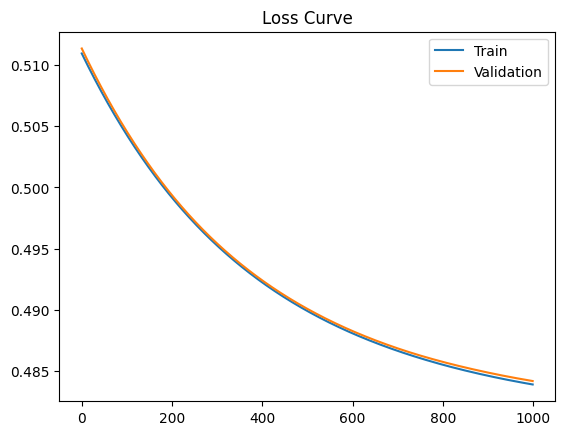

In [109]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train","Validation"])
plt.title("Loss Curve")
plt.savefig(f"{project_path}/loss_curves.png")
plt.show()

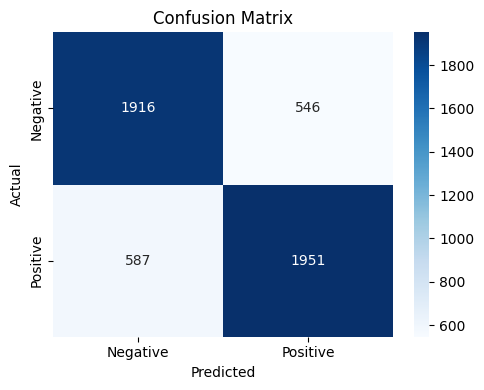

In [110]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{project_path}/confusion_matrix.png")
plt.show()

Submission

In [111]:
submission = pd.DataFrame({
    "id": range(len(predictions)),
    "label": predictions.flatten()
})

submission.to_csv(f"{project_path}/submission.csv", index=False)